In [1]:
import os
import torch
import pynvml
import numpy as np
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.models import resnet50
from FDResnet50 import FDResNet, resnet50_fdconv
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from utils import print_generalized_model_summary
from torch.utils.tensorboard import SummaryWriter
from train_utils import train_model, evaluate_model, plot_training_history

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
is_cuda = torch.cuda.is_available()
device = "cuda" if is_cuda else "cpu"
print("Device:", device)

if is_cuda:
    print("GPU Model:", torch.cuda.get_device_name(0))
    
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)

    info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    print(f"Total VRAM:     {info.total / 1024**3:.2f} GB")
    print(f"Used VRAM:      {info.used / 1024**3:.2f} GB")
    print(f"Free VRAM:      {info.free / 1024**3:.2f} GB")

Device: cuda
GPU Model: NVIDIA GeForce RTX 2060
Total VRAM:     6.00 GB
Used VRAM:      0.44 GB
Free VRAM:      5.56 GB


In [4]:
train_dir = "/home/iot/Garbage/Violence_Detection/data/train"
val_dir = "/home/iot/Garbage/Violence_Detection/data/val"
test_dir = "/home/iot/Garbage/Violence_Detection/data/test"

In [5]:
image_size = (224, 224)

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(root=train_dir, transform=transform)
val_dataset = ImageFolder(root=val_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

class_names = train_dataset.classes
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Number of classes: 2
Class names: ['NonViolence', 'Violence']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.46476585..1.323268].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.490453..1.3494118].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48189062..1.4801308].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48189062..1.5062746].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7677125].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5161401..1.8

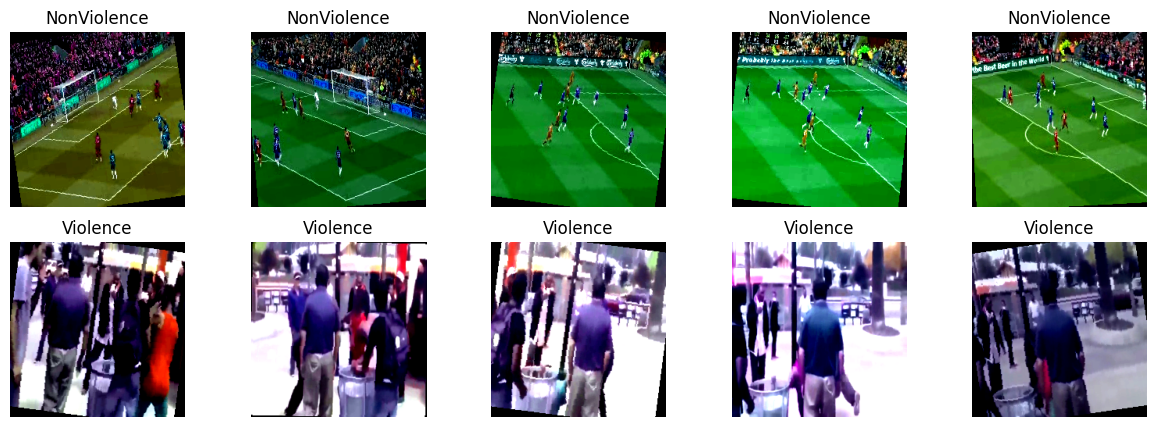

In [6]:
def show_class_samples(dataset, class_names, num_samples=5):
    plt.figure(figsize=(15, 5))
    class_to_idx = dataset.class_to_idx
    
    for c_idx, class_name in enumerate(class_names):
        target_idx = class_to_idx[class_name]
        indices = [i for i, (_, label) in enumerate(dataset.samples) if label == target_idx]
        chosen_indices = indices[:num_samples]
        
        for j, idx in enumerate(chosen_indices):
            img, label = dataset[idx]
            img = img.permute(1, 2, 0) * 0.5 + 0.5
            
            plt.subplot(len(class_names), num_samples, c_idx * num_samples + j + 1)
            plt.imshow(img)
            plt.title(f"{class_name}")
            plt.axis('off')
    plt.show()

show_class_samples(train_dataset, class_names, num_samples=5)

In [7]:
batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

train_counts = np.bincount([label for _, label in train_dataset.samples], minlength=num_classes)
val_counts = np.bincount([label for _, label in val_dataset.samples], minlength=num_classes)
test_counts = np.bincount([label for _, label in test_dataset.samples], minlength=num_classes)

print(f"Number of training samples: {len(train_dataset)}, class distribution: {dict(zip(class_names, train_counts))}")
print(f"Number of validation samples: {len(val_dataset)}, class distribution: {dict(zip(class_names, val_counts))}")
print(f"Number of test samples: {len(test_dataset)}, class distribution: {dict(zip(class_names, test_counts))}")

Number of training samples: 7256, class distribution: {'NonViolence': 3842, 'Violence': 3414}
Number of validation samples: 1561, class distribution: {'NonViolence': 840, 'Violence': 721}
Number of test samples: 1579, class distribution: {'NonViolence': 840, 'Violence': 739}


In [ ]:
# resnet_model = resnet50(weights=None)

# # for param in resnet_model.parameters():
# #     param.requires_grad = False

# in_features = resnet_model.fc.in_features
# resnet_model.fc = nn.Linear(in_features, num_classes)

# print(f"ResNet50 model created from scratch with {num_classes} output classes")
# print("\nResnet50 Model Summary:")
# print_generalized_model_summary(resnet_model, model_name="Resnet50")

In [ ]:
# num_epochs = 50
# learning_rate = 0.001
# weight_decay = 1e-4
# patience = 3
# criterion = nn.CrossEntropyLoss()

# # Train the entire model, not just the classifier
# optimizer = torch.optim.Adam(resnet_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience)

# save_dir = "./saved_models/resnet50/"
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)

# log_dir = "./runs/resnet50/"
# if not os.path.exists(log_dir):
#     os.makedirs(log_dir)
# writer = SummaryWriter(log_dir=log_dir)

# resnet_model = resnet_model.to(device)

# # Updated function call with correct parameter order
# resnet_model, history = train_model(
#     model=resnet_model,
#     criterion=criterion,
#     optimizer=optimizer,
#     scheduler=scheduler,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     writer=writer,
#     num_epochs=num_epochs,
#     device=device,
#     model_name="Resnet50",
#     early_stopping_patience=3,
#     save_dir=save_dir,
#     save_best_only=True
# )

In [ ]:
# plot_training_history(history, model_name="Resnet50")

In [ ]:
# # Evaluate the trained model on test set
# acc, pre, rec, f1 = evaluate_model(
#     model=resnet_model, 
#     test_loader=test_loader, 
#     device=device, 
#     model_name="ResNet50", 
#     class_names=class_names
# )

In [ ]:
# # Release the GPU occupied memory
# del resnet_model
# if is_cuda:
#     torch.cuda.empty_cache()

In [8]:
# Initialize FD-Conv ResNet50 model
fdconv_resnet_model = resnet50_fdconv(num_classes=num_classes, pretrained=False)
print(f"\nFD-Conv ResNet50 model created from scratch with {num_classes} output classes")
print("\nFD-Conv ResNet50 Model Summary:")
print_generalized_model_summary(fdconv_resnet_model, model_name="FD-Conv ResNet50")


FD-Conv ResNet50 model created from scratch with 2 output classes

FD-Conv ResNet50 Model Summary:
                                     Generalized Model Summary                                      
Model Name: FD-Conv ResNet50
Model Family: Unknown
Device: CUDA
Precision: float32

Parameter Analysis:
  ├─ Trainable Parameters: 27,461,354
  ├─ Non-trainable Parameters: 0
  └─ Total Parameters: 27,461,354

Memory Analysis:
  ├─ Model Size: 195.06 MB
  ├─ Input Tensor: 0.57 MB
  ├─ Estimated Activations: 1.15 MB
  └─ Total Estimated: 196.78 MB

Input/Output Analysis:
  ├─ Input Shape: (1, 3, 224, 224)
  ├─ Output Shape: (1, 2)
  └─ Number of Classes: 2

Architecture Analysis:
  ├─ Total Layers: 658
  ├─ Has FDConv: Yes
  ├─ Has Attention: No
  └─ Has Normalization: Yes

Layer Type Distribution:
  ├─ Conv2d: 273
  ├─ BatchNorm2d: 105
  ├─ ReLU: 69
  ├─ AdaptiveAvgPool2d: 53
  ├─ FDConv: 52
  ├─ Conv1d: 52
  ├─ LayerNorm: 52
  ├─ MaxPool2d: 1
  └─ Linear: 1

Special Features:
  ├─ FDConv

In [9]:
# FD-Conv ResNet50 Training Configuration with Memory Optimization
num_epochs = 50
learning_rate = 1e-5
weight_decay = 1e-4
patience = 3


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fdconv_resnet_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience)

save_dir = "./saved_models/fdresnet50/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

log_dir = "./runs/fdresnet50/"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
writer = SummaryWriter(log_dir=log_dir)

fdconv_resnet_model = fdconv_resnet_model.to(device)


# Updated function call with smaller data loaders for memory efficiency
fdconv_resnet_model, history = train_model(
    model=fdconv_resnet_model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    writer=writer,
    num_epochs=num_epochs,
    device=device,
    model_name="FDConv_ResNet50",
    early_stopping_patience=5,
    save_dir=save_dir,
    save_best_only=True,
    warmup_epochs=10,
    max_grad_norm=0.5,
    monitor_gradients=True,
    memory_efficient=True
)

Training Configuration:
  Model: FDConv_ResNet50
  Epochs: 50 (starting from 1)
  Device: CUDA
  Mixed Precision: False
  Gradient Clipping: 0.5
  Accumulation Steps: 1
  Warmup Epochs: 10
  Initial GPU Memory: 0.29 GB
Training started for 50 remaining epochs


[Epoch 1/50] T_Loss: 0.7397 , T_Acc: 51.49% | V_Loss: 66228689421.1142 , V_Acc: 50.74% | Best_V_Acc: 50.74% | LR: 0.000001 | Time: 634.19s | Memory: 0.63GB



Training interrupted by user.
Loaded best model weights from epoch 1

Training complete.
Best Validation Accuracy: 50.74% (Epoch 1)
Total training steps: 1884
Final GPU Memory Usage: 2.90 GB


In [ ]:
plot_training_history(history, model_name="FD-Conv ResNet50")

In [ ]:
evaluate_model(
    model=fdconv_resnet_model, 
    test_loader=test_loader, 
    device=device, 
    model_name="FD-Conv ResNet50", 
    class_names=class_names
)